# Задание 6
Седых Иван Дмитриевич БПМ181

In [1]:
import math

import numpy as np
import tqdm
from matplotlib import pyplot as plt
from scipy import interpolate, optimize, linalg


np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=120)
plt.style.use('ggplot')

In [2]:
with np.load('data_7_1.npz') as data :
    x1, y1 = data['x1'], data['y1']

[   0.  349.  698. 1047. 1396. 1746. 2095. 2444. 2793. 3142. 3492. 4190. 4889. 5587. 6285. 6984. 7682. 8381. 9079.
 9778.]
[-0.99       -0.98961838 -0.98749461 -0.98666501 -0.98641613 -0.98628339 -0.98611747 -0.98610088 -0.98583541
 -0.98583541 -0.98556994 -0.91289696 -0.1005857  -0.09056413 -0.08454123 -0.08233449 -0.08079144 -0.07750622
 -0.07218019 -0.05817654]


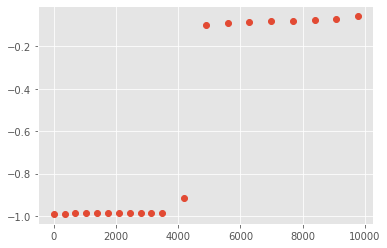

In [3]:
print(x1)
print(y1)
plt.plot(x1, y1, 'o');

---
## Task 1

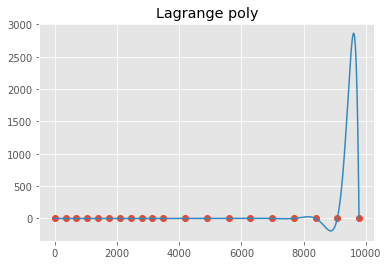

In [4]:
lagrange_poly = interpolate.lagrange(x1, y1)

xx = np.linspace(x1.min(), x1.max(), 1000)
plt.plot(x1, y1, 'o');
plt.plot(xx, lagrange_poly(xx));
plt.title('Lagrange poly');

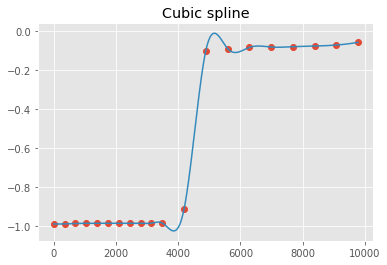

In [5]:
cubic_spline = interpolate.CubicSpline(x1, y1)

xx = np.linspace(x1.min(), x1.max(), 1000)
plt.plot(x1, y1, 'o');
plt.plot(xx, cubic_spline(xx));
plt.title('Cubic spline');

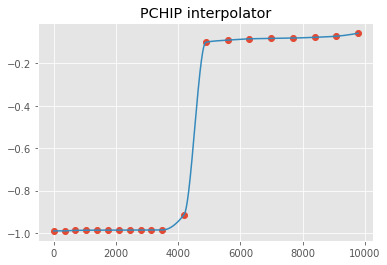

In [6]:
pchip = interpolate.PchipInterpolator(x1, y1)

xx = np.linspace(x1.min(), x1.max(), 1000)
plt.plot(x1, y1, 'o');
plt.plot(xx, pchip(xx));
plt.title('PCHIP interpolator');

---
## Task 2

/Users/sedyhivan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sedyhivan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sedyhivan/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


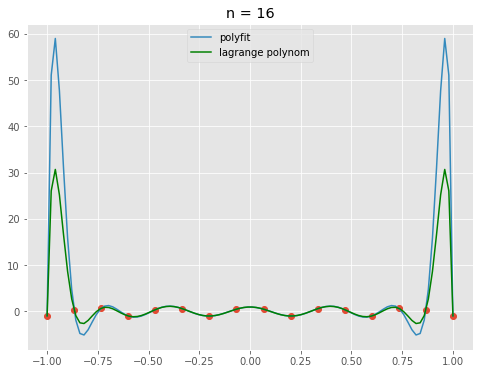

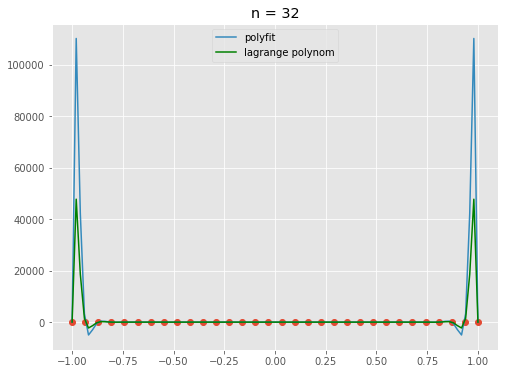

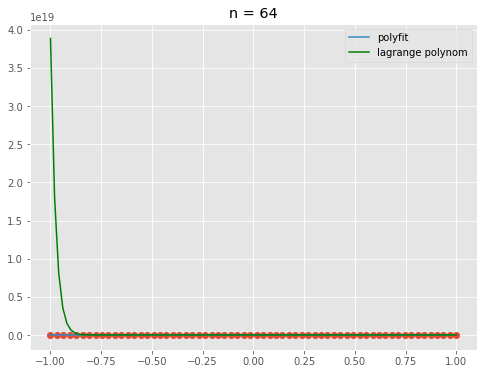

In [7]:
for n in [16, 32, 64]:

    x = np.linspace(-1, 1, n)
    y = np.cos(n * x)


    p = np.polyfit(x, y, deg=n)
    lagrange_poly = interpolate.lagrange(x, y)

    plt.figure(figsize=(8, 6));
    plt.title(f"n = {n}")
    plt.plot(x, y, 'o');
    xx = np.linspace(-1, 1, 100)
    plt.plot(xx, np.polyval(p, xx), label='polyfit');
    plt.plot(xx, lagrange_poly(xx), label='lagrange polynom', c='green');
    plt.legend();

---
## Task 3

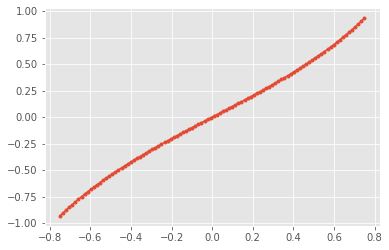

In [8]:
with np.load('data_7_1.npz') as data :
    x4, y4 = data['x4'], data['y4']

plt.plot(x4, y4, '.-');

In [9]:
def f1(x, p0, p1, p2, p3, p4, p5):
    return np.polyval([p0, p1, p2, p3, p4, p5], x)

def f2(x, p0, p1, p2, p3, q1, q2):
    return np.polyval([p0, p1, p2, p3], x) / (1 + q1 * x + q2 * x**2)


params_1, _ = optimize.curve_fit(f1, x4, y4)
params_2, _ = optimize.curve_fit(f2, x4, y4)

In [10]:
mse_f1 = np.mean((y4 - f1(x4, *params_1))**2)
mse_f2 = np.mean((y4 - f2(x4, *params_2))**2)
print(f"MSE f1 = {mse_f1}")
print(f"MSE f2 = {mse_f2}")

MSE f1 = 1.623748456103594e-08
MSE f2 = 1.4010819677796178e-12


Видим, что в терминах MSE **первая функция лучше**, хотя они обе в принципе молодцы.

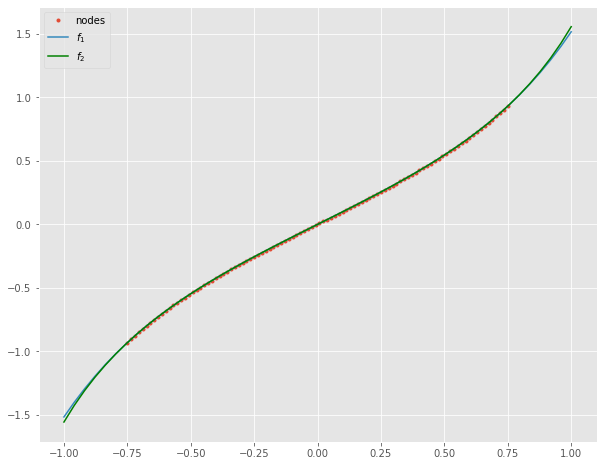

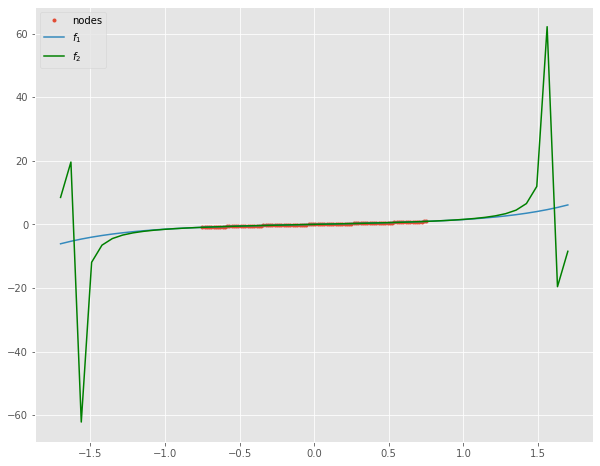

In [11]:
def make_plot(limit):
    plt.figure(figsize=(10, 8))
    plt.plot(x4, y4, '.', label='nodes');
    xx = np.linspace(-limit, limit)
    plt.plot(xx, f1(xx, *params_1), label='$f_1$');
    plt.plot(xx, f2(xx, *params_2), label='$f_2$', c='green');
    plt.legend();

make_plot(1);
make_plot(1.7);

Угадать истинную функцию я не могу.

---
## Task 4

In [12]:
f = lambda x: np.sin(x*(2*np.pi))

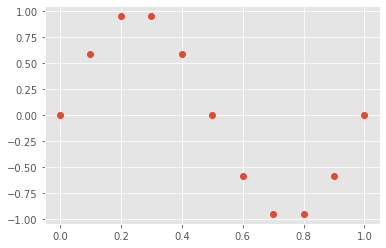

In [13]:
n = 11
xs = np.linspace(0, 1, n)
ys = f(xs)
plt.plot(xs, ys, 'o');

In [14]:
class PeriodicCubicSpline():
    def __init__(self, xs, ys):
        xs = np.asarray(xs)
        ys = np.asarray(ys)
        self.xs = xs
        self.ys = ys
        self.n = xs.shape[0]
        self.coefs = self.get_coefs(xs, ys)

    def __call__(self, *args):
        return self.predict(*args)

    def predict(self, x):
        k = max(0, sum(self.xs < x) - 1) # select interval number
        coef = self.coefs[k]
        return np.polynomial.polynomial.polyval(x - self.xs[k], coef)

    def get_coefs(self, xs, ys):
        assert np.allclose(ys[0], ys[-1]), 'need peridocity'
        h = np.diff(xs)
        a = ys[:-1]

        A = np.zeros((n-1, n-1))
        for i in range(n-1):
            A[i, i] = 2 * (h[i] + h[i-1])
            A[i, i-1] = h[i-1]
            A[i-1, i] = h[i-1]
        z = 3 * ( 1/h * (np.roll(a, -1) - a) - 1/np.roll(h, 1) * (a - np.roll(a, 1)) )
        c = self.solve_system(A, z)

        d = (np.roll(c, -1) - c) / (3 * h)
        b = (np.roll(a, -1) - a) / h - (2 * c + np.roll(c, -1))/3 * h

        coefs = np.column_stack([a,b,c,d], )
        return coefs

    def solve_system(self, A, b):
        return np.linalg.solve(A, b)

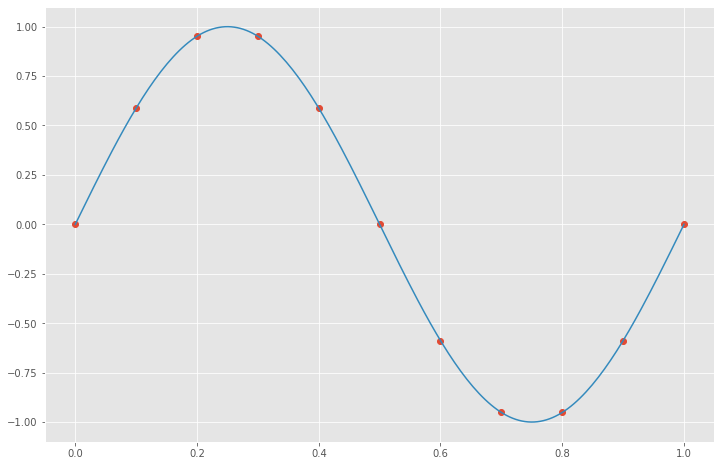

In [15]:
p = PeriodicCubicSpline(xs, ys)

xxx = np.linspace(0, 1, 200)
yyy = [p(x) for x in xxx]

plt.figure(figsize=(12, 8))
plt.plot(xs, ys, 'o');
plt.plot(xxx, yyy, '-');

Белиссимо! Очень гладко и круто!

---
## Task 5

Прикол в том, что мы умеем решать трехдиагональные системы за линейное время.  
Еще мы умеем эффективно пересчитывать решения для одноранговых обновлений.

Соединим эти 2 техники и получим способ считать циклические трехдиагональные системы.

[Numerical Recipes, гл. 2.7.3]

In [16]:
def solve_cyclic_tridiag(A, b):
    gamma = A[0, 0] # we can choose arbitrary
    alpha = A[-1, 0]
    beta = A[0, -1]
    u = np.zeros_like(A[:, 0])
    u[0] = gamma
    u[-1] = alpha
    v = np.zeros_like(u)
    v[0] = 1
    v[-1] = beta / gamma
    A -= np.outer(u, v) # now we have tridiag matrix

    Ab = np.zeros((3, A.shape[0]))
    Ab[0, 1:] = np.diagonal(A, -1)
    Ab[1, :] = np.diagonal(A, 0)
    Ab[2, :-1] = np.diagonal(A, -1)
    y = linalg.solve_banded((1, 1), Ab, b)
    z = linalg.solve_banded((1, 1), Ab, u)
    x = y - z * ( (v@y) / (1 + v@z))
    return x

In [17]:
h = np.ones(n-1) * 0.1
A = np.zeros((n-1, n-1))
for i in range(n-1):
    A[i, i] = 2 * (h[i] + h[i-1])
    A[i, i-1] = h[i-1]
    A[i-1, i] = h[i-1]
b = np.random.rand(n-1)
print(A)

true_x = np.linalg.solve(A, b)
my_x = solve_cyclic_tridiag(A, b)
assert np.allclose(true_x, my_x), 'wrong implementation'
print('OK')

[[0.4 0.1 0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.1 0.4 0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.4 0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.4 0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.4 0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.4 0.1 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.4 0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.4 0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.4 0.1]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.1 0.4]]
OK


In [18]:
class PeriodicCubicSpline_FAST(PeriodicCubicSpline):
    def solve_system(self, A, b):
        return solve_cyclic_tridiag(A, b)

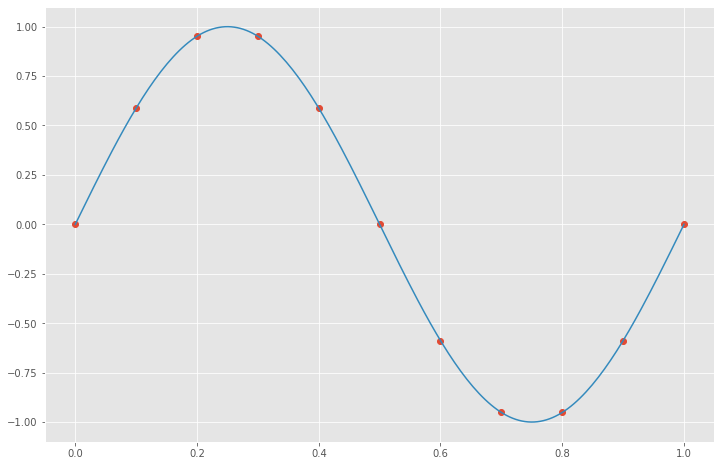

In [19]:
p = PeriodicCubicSpline_FAST(xs, ys)

xxx = np.linspace(0, 1, 200)
yyy = [p(x) for x in xxx]

plt.figure(figsize=(12, 8))
plt.plot(xs, ys, 'o');
plt.plot(xxx, yyy, '-');

### benchmark

Сгенерируем побольше точек и засечем время работы

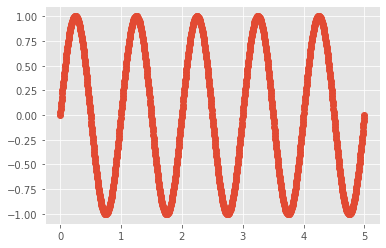

In [24]:
n = 1000
xs = np.linspace(0, 5, n)
ys = f(xs)
plt.plot(xs, ys, 'o');

In [21]:
%%timeit
p = PeriodicCubicSpline(xs, ys)

24.7 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
p = PeriodicCubicSpline_FAST(xs, ys)

7.84 ms ± 636 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Видим ускорение в 4 раза